In [3]:
import pandas as pd
from typing import List, Mapping
import numpy as np


In [4]:
raw = pd.read_excel("./data/Stafflist and Attrition.xlsb")

In [5]:
raw

,Active Stafflist @ Dec 2022,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100
0,C,C,C,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C
1,NaN,NaN,NaN,New PG,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Category (New),NaN,NaN
2,Company,Staff ID Code,Status,PG Range,Level 1 Code,Level 2 Code,Position Code,Sales/ Primary / Support,DIA,Date Join Group,...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Talent,High Performer,Performance Category
3,Company 1,A00001,Permanent,R7-R9,A01,B01,RB0522,Primary,Non DIA,30452,...,1,1,1,1,1,1,1,0,1,High Performer
4,Company 1,A00002,Permanent,R1-R3,A01,B02,RB0565,Support,Non DIA,30536,...,1,1,1,1,1,1,1,0,1,High Performer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12589,Company 1,A12599,Contract,R1-R3,A02,B20,RB0370,Support,Non DIA,44916,...,0,0,0,0,0,0,1,0,0,No Rating
12590,Company 1,A12600,Probationer,R1-R3,A02,B20,CM0131,Primary,Non DIA,44916,...,0,0,0,0,0,0,1,0,0,No Rating
12591,Company 1,A12601,Permanent,R7-R9,A03,B07,CB0075,Support,Non DIA,41426,...,1,1,1,1,1,1,1,0,0,Solid Performer
12592,Company 1,A13269,Permanent,R7-R9,A12,B90,0,Sales,Non DIA,40133,...,1,1,1,1,1,1,1,0,0,Solid Performer


# Objective - Forecast the HR Operating Costs

In [6]:
raw_actual = pd.read_excel("./data/Cost (without BP).xlsx", sheet_name="Act Cost Jan22-Dec23")
raw_manual = pd.read_excel("./data/Cost (without BP).xlsx", sheet_name="Bud Cost Jan22-Dec23")

# Preprocess
- Trailing spaces in Level4

In [7]:
# Same preprocessing format applies to actual and manual data
def preprocess_data(
    df: pd.DataFrame,
    time_col: str,
    entity_col: str,
    target_col: str,
    filter_col: str,
    filter_value: str,
) -> pd.DataFrame:
    new_df = (
        df[df[filter_col] == filter_value]
        # Groupby The lowest level and date
        .groupby([time_col, entity_col])
        # Aggregate the amount to sum
        .agg({target_col: "sum"})
        # Reset entity_col
        .reset_index()
        # Assign a new column (overwite the existing Date) with the date at start of the month instead
        # NOTE: This is because most ML models use start of the day in month 
        .assign(Date=lambda df: df['Date'].dt.to_period('M').dt.to_timestamp())
        # Set index as time for sorting
        .set_index("Date")
        .sort_index()
        # Remove trailing and leading empty spaces for entity_col
        .assign(entity_col=lambda df: df[entity_col].str.strip())
        # Drop the original index col
        .loc[:, ["entity_col", target_col]]
        # Rename the new entity_col back to original name
        .rename(columns={"entity_col": entity_col})
    )
    return new_df


# actual = (
#     # Filter to only HR Costs
#     raw_actual[raw_actual["Group2"] == "HR Cost (RM'000)"]
#     # Groupby The lowest level and date
#     .groupby(["Level4", "Date"])
#     # Aggregate the amount to sum
#     .agg({"Amount": "sum"})
#     .reset_index()
#     # # Assign a new column (overwite the existing Date) with the date at start of the month instead
#     # .assign(Date=lambda df: df['Date'].dt.to_period('M').dt.to_timestamp())
#     # Remove trailing and leading empty spaces for entity_col
#     .assign(entity_col=lambda df: df["Level4"].str.strip())
#     # Set index to time and sort by ascending
#     .set_index("Date")
#     .sort_index()
#     .reset_index()
#     # Drop the original index col
#     .loc[:, ["Date", "entity_col", "Amount"]]
#     # Rename all columns to lowercase
#     .rename(columns={"entity_col": entity_col})
# )

In [206]:
actual = preprocess_data(
    df=raw_actual,
    time_col="Date",
    entity_col="Level4",
    target_col="Amount",
    filter_col="Group2",
    filter_value="HR Cost (RM'000)",
)
actual

,Level4,Amount
Date,,
2022-01-01,Project RACE Program,332.566014
2022-01-01,HR Business Partner,322.225926
2022-01-01,AGILE Coaches,535.704551
2022-01-01,Group Asset Management,5676.954039
2022-01-01,Group Community Banking,61394.791283
...,...,...
2023-12-01,HR Pool,0.000000
2023-12-01,HR Strategy & Org Development,11593.014700
2023-12-01,Mgt. Assoc. Programme,1633.644933


In [207]:
manual = preprocess_data(
    df=raw_manual,
    time_col="Date",
    entity_col="Level4",
    target_col="Amount",
    filter_col="Group2",
    filter_value="HR Cost (RM'000)",
)
manual

,Level4,Amount
Date,,
2022-01-01,Project RACE Program,349.675497
2022-01-01,HR Business Partner,332.992616
2022-01-01,AGILE Coaches,0.000000
2022-01-01,Group Asset Management,5521.967695
2022-01-01,Group Community Banking,62415.523873
...,...,...
2023-12-01,HR Pool,0.000000
2023-12-01,HR Strategy & Org Development,9124.886608
2023-12-01,Mgt. Assoc. Programme,2607.206907


In [208]:
categories = actual["Level4"].unique()
categories

array(['Project RACE Program', 'HR Business Partner', 'AGILE Coaches',
       'Group Asset Management', 'Group Community Banking',
       'Group Compliance', 'Group Finance', 'Group Human Resource',
       'Group Insurance', 'Group Internal Audit',
       'Group International Business', 'Group Investment Banking',
       'Group Legal, Secretariat & Gov',
       "Group Managing Director's Office", 'Group Marketing',
       'Group Operations', 'Group Risk & Credit Management',
       'Group Shariah Business', 'Group Strategy & Innovation',
       'Group Sustainability & Corporate Communications',
       'Group Technology', 'Group Wholesale Banking',
       'HR Center of Excellence (CoE)', 'HR Cost: HRD90', 'HR Pool',
       'HR Strategy & Org Development', 'Mgt. Assoc. Programme',
       'Others and Consol Adjustment', 'Project Mgmt & Transformation'],
      dtype=object)

In [209]:
# Remove HR Pool as it has null values
actual = actual[actual["Level4"] != "HR Pool"]

In [210]:
panel_data = actual.reset_index().set_index(["Level4", "Date"]).sort_index()

In [211]:
# Snapshot of data
panel_data.info()
panel_data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 672 entries, ('AGILE Coaches', Timestamp('2022-01-01 00:00:00')) to ('Project RACE Program', Timestamp('2023-12-01 00:00:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  672 non-null    float64
dtypes: float64(1)
memory usage: 8.7+ KB


Amount
Level4               Date                   
AGILE Coaches        2022-01-01   535.704551
                     2022-02-01  1085.919443
                     2022-03-01  1871.860783
                     2022-04-01  2442.484811
                     2022-05-01  2968.431818
...                                      ...
Project RACE Program 2023-08-01  2951.232876
                     2023-09-01  2951.232876
                     2023-10-01  2951.232876
                     2023-11-01  2951.232876
                     2023-12-01  2951.232876

[672 rows x 1 columns]

# Machine Learning - Vanilla (Linear Regression)

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [413]:
entity_col = "Level4"
time_col = "Date"
target_col = "Amount"
entity = "Group Operations"

In [414]:
# Convert timestamp to numeric value for simplicity (you might need more sophisticated preprocessing)
# Only get the entity to test
lr_data = panel_data.reset_index().pipe(lambda df: df[df[entity_col]== entity])
# Have to convert datetime to numeric for LR
lr_data[time_col] = pd.to_numeric(lr_data[time_col])

# Splitting data into train and test sets
train_df, test_df = train_test_split(lr_data, test_size=0.2, shuffle=False)  # Ensure no data leakage


In [415]:
# Extracting features and target variables
X_train = train_df[time_col].values.reshape(-1, 1) # Change it to array and reshape for single feature
y_train = train_df[target_col]

X_test = test_df[time_col].values.reshape(-1, 1) # Change it to array and reshape for single feature
y_test = test_df[target_col]

In [416]:
# Creating and training the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [417]:
# Making predictions - based on last 5 timestamp integer
y_pred = model.predict(X_test)

In [418]:
# Calculating Mean Squared Error (MSE) as a basic evaluation metric
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 2781641898.883357
Mean Absolute Percentage Error: 0.302129236295163
Mean Absolute Error: 49347.49502776228


In [426]:
# Get actual by entity dataframe
actual_by_entity = (
    # Parse datetime
    lr_data.assign(Date=lambda df: pd.to_datetime(df["Date"]))
    # Rename target_col to Actual
    .rename(columns={"Amount": "Actual"})
    # Drop entity_col
    # .drop("Level4", axis=1)
    .set_index(["Date", "Level4"])
)

# Get manual dataframe in same format
manual_by_entity = (
    manual.reset_index()
    # Filter by selected entity
    .pipe(lambda df: df[df[entity_col] == entity])
    # Rename target_col to Actual
    .rename(columns={"Amount": "Manual"})
    # Drop entity_col
    # .drop("Level4", axis=1)
    # Set index as Date
    .set_index(["Date", "Level4"])
)

# # Get the last n datetime index based on y_pred length
# idx_pred = actual_by_entity.index[-len(y_pred) :]
# # Combine index to y_pred values
# forecast_by_entity = pd.DataFrame({"Date": idx_pred, "Forecast": y_pred}).set_index(
#     "Date"
# )

# # Combine actual, manual and forecast into single dataframe
# chart_data = actual_by_entity.join(manual_by_entity)


In [429]:
actual_by_entity

,,Actual
Date,Level4,
2022-01-01,Group Operations,13102.142483
2022-02-01,Group Operations,26671.888323
2022-03-01,Group Operations,41346.458707
2022-04-01,Group Operations,55007.107174
2022-05-01,Group Operations,69175.938173
2022-06-01,Group Operations,83214.179231
2022-07-01,Group Operations,97484.263579
2022-08-01,Group Operations,114406.618520
2022-09-01,Group Operations,129978.532333


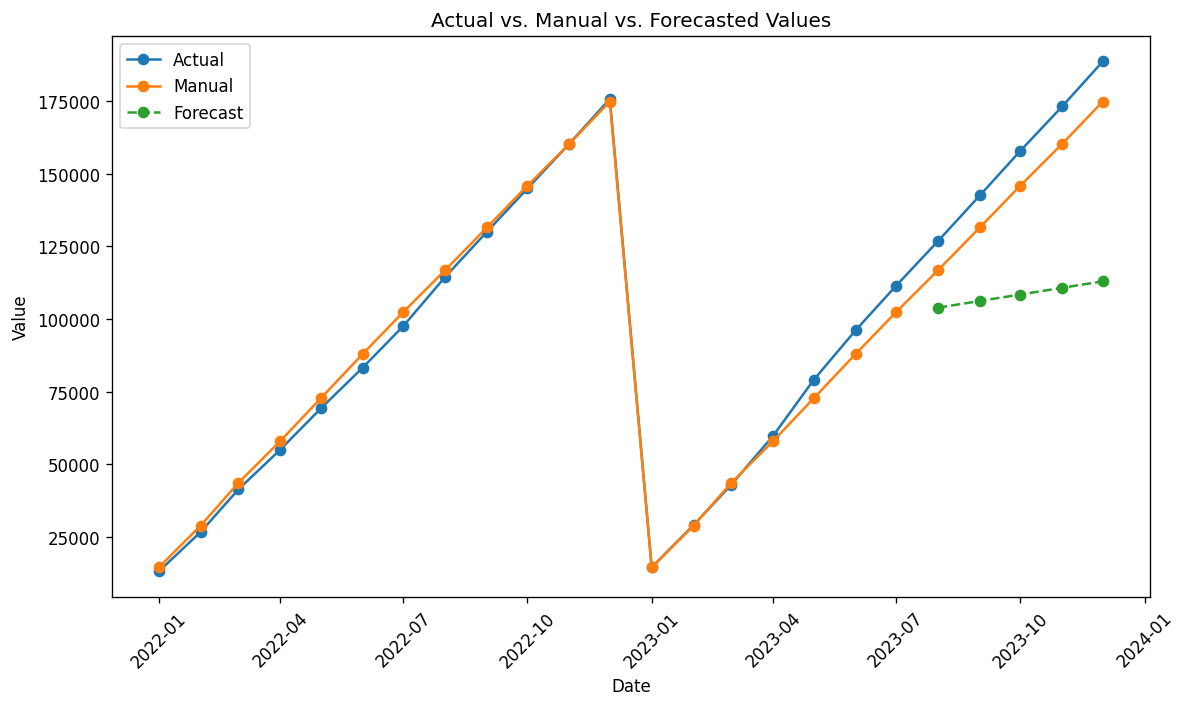

In [421]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot actual values
ax.plot(chart_data.index, chart_data['Actual'], marker='o', label='Actual')
# Plot manual values
ax.plot(chart_data.index, chart_data['Manual'], marker='o', label='Manual')
# Plot forecasted values
ax.plot(chart_data.index, chart_data['Forecast'], marker='o', linestyle='dashed', label='Forecast')
# Add title and labels
ax.set_title('Actual vs. Manual vs. Forecasted Values')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
# Add legend
ax.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Show the plot
plt.tight_layout()
plt.show()

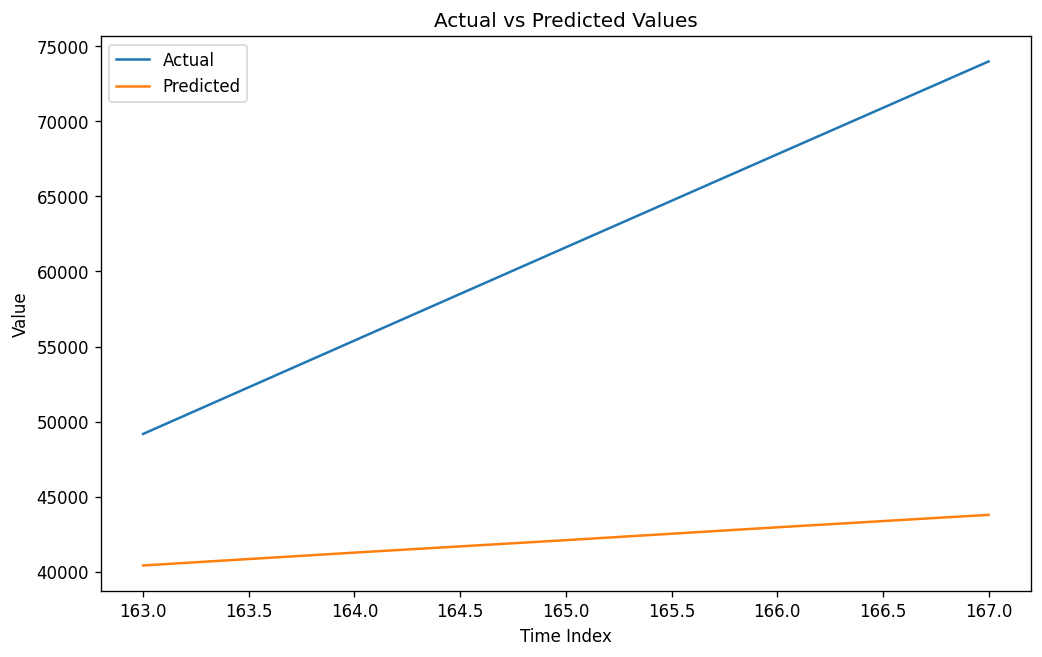

In [249]:
# Creating a DataFrame for visualization
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [250]:
def linear_regression(entity_col: str, time_col: str, target_col: str, entities: List[str]):
    results = {}
    for entity in entities:
        # Only get the specific entity to forecast
        lr_data = panel_data.reset_index().pipe(lambda df: df[df[entity_col]== entity])
        # Have to convert datetime to numeric for LR
        lr_data[time_col] = pd.to_numeric(lr_data[time_col])

        # Splitting data into train and test sets
        train_df, test_df = train_test_split(lr_data, test_size=0.2, shuffle=False)  # Ensure no data leakage

        # Extracting features and target variables
        X_train = train_df[time_col].values.reshape(-1, 1) # Change it to array and reshape for single feature
        y_train = train_df[target_col]

        X_test = test_df[time_col].values.reshape(-1, 1) # Change it to array and reshape for single feature
        y_test = test_df[target_col]
        
        # Creating and training the Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Making predictions - based on last 5 timestamp integer
        y_pred = model.predict(X_test)
        
        # Calculating Mean Squared Error (MSE) as a basic evaluation metric
        mse = mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Percentage Error: {mape}")
        print(f"Mean Absolute Error: {mae}")
        
        # Creating a DataFrame for visualization
        results[entity] = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        print(results[entity])

        # Plotting the line chart
        plt.figure(figsize=(10, 6))
        plt.plot(results_df.index, results_df['Actual'], label='Actual')
        plt.plot(results_df.index, results_df['Predicted'], label='Predicted')
        plt.xlabel('Time Index')
        plt.ylabel('Value')
        plt.title('Actual vs Predicted Values')
        plt.legend()
        plt.show()
        
    return results
            

Mean Squared Error: 437499146.46318376
Mean Absolute Percentage Error: 0.3049610085487557
Mean Absolute Error: 19493.78624055664
           Actual     Predicted
163  49174.260260  40410.698207
164  55397.947185  41267.535649
165  61608.800326  42096.733173
166  67806.820111  42953.570615
167  73992.409102  43782.768139


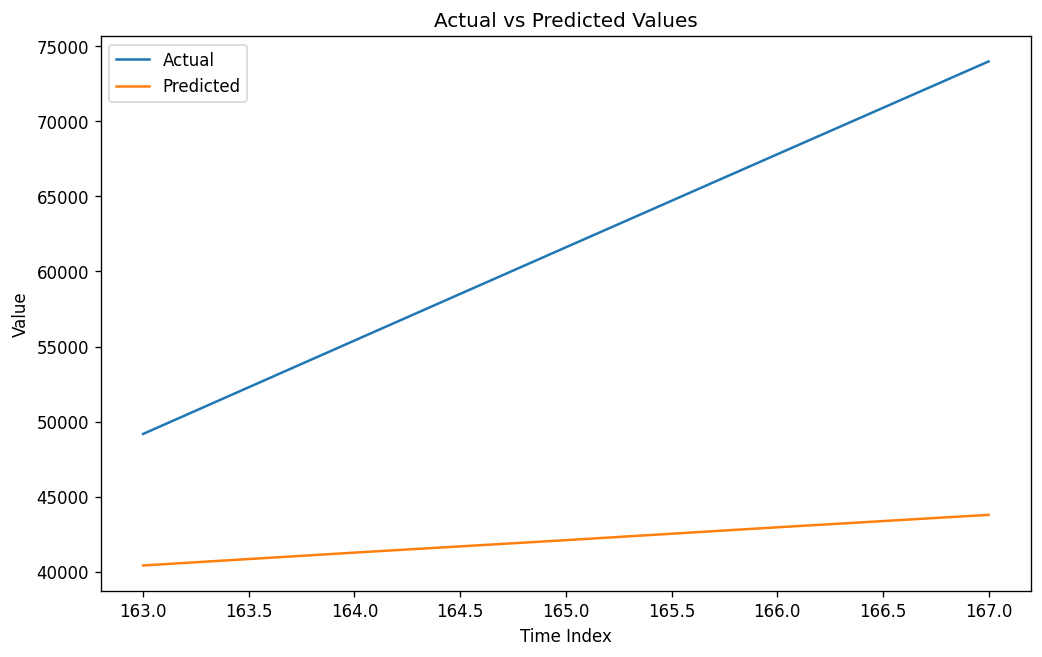

Mean Squared Error: 206585.9572137752
Mean Absolute Percentage Error: 0.25718847973247105
Mean Absolute Error: 397.9663843964477
          Actual    Predicted
139  1071.905104   984.268555
140  1254.849334  1012.410995
141  1437.793564  1039.645616
142  1620.737794  1067.788056
143  1803.682025  1095.022677


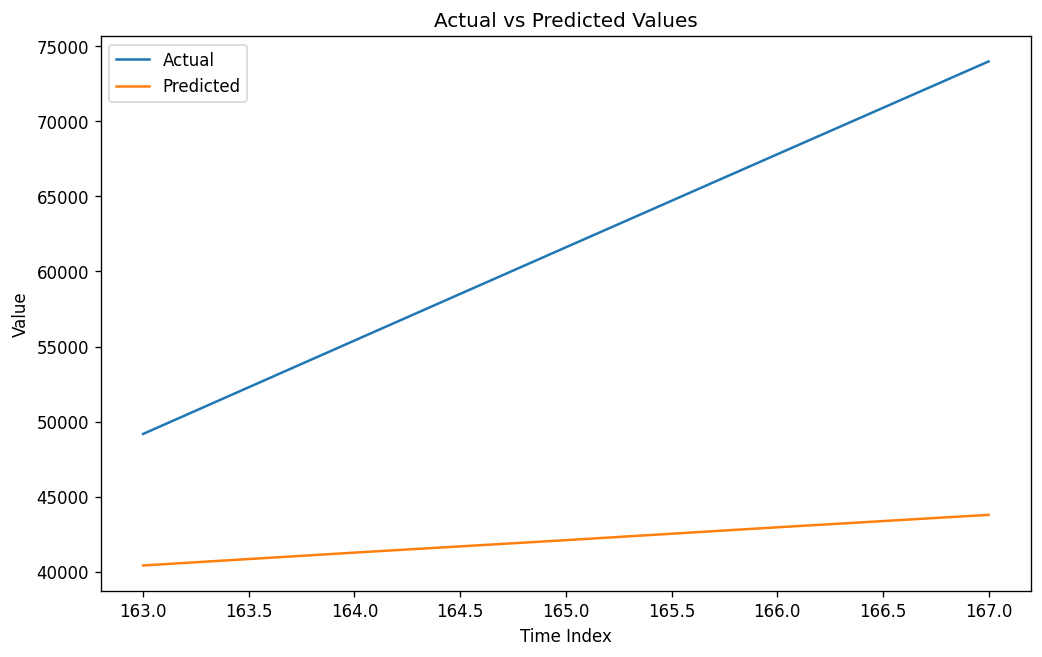

Mean Squared Error: 2781641898.883357
Mean Absolute Percentage Error: 0.302129236295163
Mean Absolute Error: 49347.49502776228
            Actual      Predicted
331  126756.627263  103852.920912
332  142471.751811  106155.624077
333  157815.755209  108384.046494
334  173118.648787  110686.749659
335  188569.205286  112915.172076


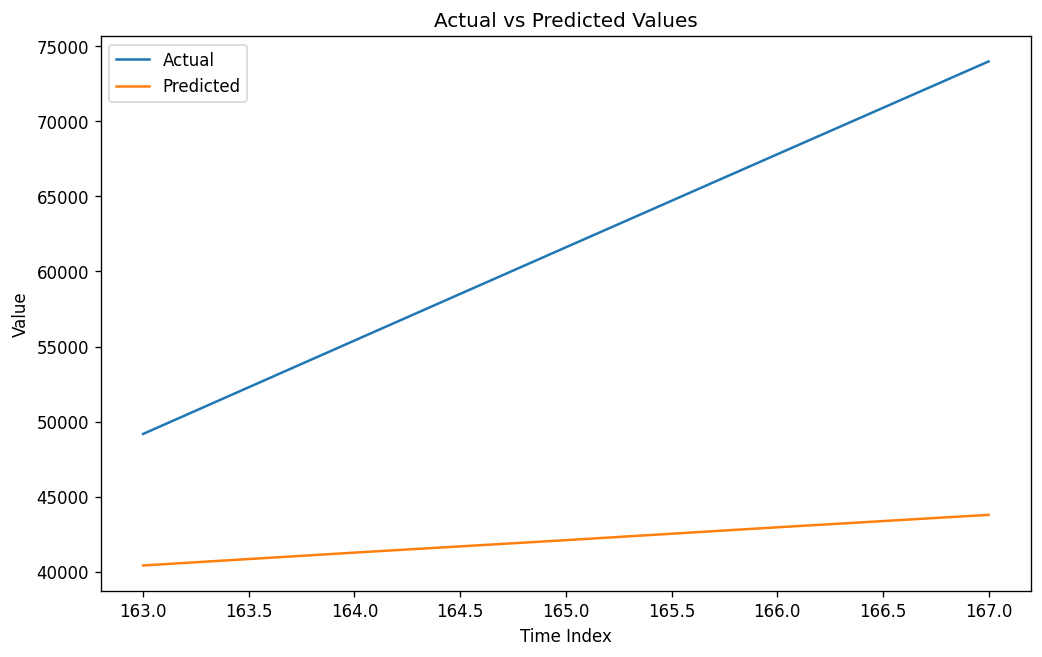

{'Group Insurance':            Actual     Predicted
 163  49174.260260  40410.698207
 164  55397.947185  41267.535649
 165  61608.800326  42096.733173
 166  67806.820111  42953.570615
 167  73992.409102  43782.768139,
 'Group Human Resource':           Actual    Predicted
 139  1071.905104   984.268555
 140  1254.849334  1012.410995
 141  1437.793564  1039.645616
 142  1620.737794  1067.788056
 143  1803.682025  1095.022677,
 'Group Operations':             Actual      Predicted
 331  126756.627263  103852.920912
 332  142471.751811  106155.624077
 333  157815.755209  108384.046494
 334  173118.648787  110686.749659
 335  188569.205286  112915.172076}

In [251]:
linear_regression(
    entity_col="Level4",
    time_col="Date",
    target_col="Amount",
    entities=["Group Insurance", "Group Human Resource", "Group Operations"],
)

# Machine Learning - Using ARIMA
ARIMA is a classical time series model that can capture autocorrelation and seasonality in data.

https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

p (Autoregressive order): This parameter represents the number of lag observations included in the model. In other words, it indicates how many past time steps will be used to predict the current value. For example, if p = 2, the model will use the previous two observations to predict the current value.

d = 0: This means no differencing is applied. If your data already appears stationary or doesn't exhibit a clear trend or seasonality, you might not need to difference the data. However, if the data has a trend or seasonality, modeling it without differencing could result in biased or spurious results.

d = 1: This indicates that the data is differenced once. It's often used when there's a clear trend in the data but no seasonality. Differencing by one order calculates the difference between consecutive observations, effectively removing the linear trend. This can help make the data stationary, which is a requirement for some time series models like ARIMA.

d > 1: Higher values of d indicate multiple levels of differencing. This can be used when the data still exhibits trends or patterns after a first-order difference. However, excessive differencing can lead to over-differencing, which might introduce noise and affect the quality of the model.

q (Moving Average order): This parameter represents the number of lagged forecast errors in the model. It determines how many past errors will be used to predict the current value. For example, if q = 2, the model will use the previous two forecast errors to predict the current value.

Requires dataset to be stationary 

Checking the stationarity of time series data is a fundamental step in time series analysis, and it's particularly important when working with models like ARIMA (AutoRegressive Integrated Moving Average). The Augmented Dickey-Fuller (ADF) test is a statistical test that helps determine whether a given time series is stationary or not. Here's why checking for stationarity is crucial:

Stationarity Requirement for ARIMA Models:
ARIMA models assume that the time series data is stationary. Stationarity implies that the statistical properties of the data, such as mean, variance, and autocorrelation, remain constant over time. ARIMA models rely on the concept of autoregression (AR) and moving average (MA), which work effectively when the data is stationary. Differencing, a process used to achieve stationarity, is a key component of ARIMA models.

Autocorrelation and Memory:
Autocorrelation, which is the correlation of a time series with its past values, is a core concept in time series analysis. If a time series is not stationary, its autocorrelation structure might be complex, making it challenging to capture with ARIMA models. Stationarity simplifies the autocorrelation structure and makes it easier to model.

Removing Trends and Seasonality:
Non-stationary data often exhibits trends and seasonality, which can lead to biased model results. By checking for stationarity and making the data stationary through processes like differencing, you can effectively remove these trends and seasonality, allowing your model to capture more meaningful patterns.

Interpretation and Forecasting:
Stationary data tends to have stable statistical properties, making it easier to interpret the model's coefficients and predictions. In contrast, non-stationary data can have erratic and unpredictable behavior that might lead to unreliable forecasts.

The Augmented Dickey-Fuller test is a commonly used tool to assess stationarity by testing whether a unit root is present in a time series. A unit root indicates non-stationarity. If the test results indicate the presence of a unit root (non-stationarity), you might need to apply differencing to make the data stationary before proceeding with ARIMA modeling.

In summary, checking the stationarity of your data using methods like the Augmented Dickey-Fuller test is crucial because it ensures that your time series is suitable for modeling using ARIMA or other time series techniques. It allows you to address issues related to trends, seasonality, and autocorrelation, which are important for accurate and reliable time series forecasting.

In [378]:
entity_col = "Level4"
time_col = "Date"
target_col = "Amount"
entity = "Group Operations"

## Preprocessing

In [379]:
# Convert timestamp to numeric value for simplicity (you might need more sophisticated preprocessing)
# Only get the entity to test
arima_data = (
    panel_data.reset_index()
    .pipe(lambda df: df[df[entity_col] == entity])
    .loc[:, [time_col, target_col]]
    .set_index(time_col)    
    .asfreq("MS")  # Set the frequency to month start ('MS')
)

# Splitting data into train and test sets
train_df, test_df = train_test_split(
    arima_data, test_size=0.2, shuffle=False
)  # Ensure no data leakage

# Extracting features and target variables
X_train = train_df.index.values.reshape(
    -1, 1
)  # Change it to array and reshape for single feature
y_train = train_df[target_col]

X_test = test_df.index.values.reshape(
    -1, 1
)  # Change it to array and reshape for single feature
y_test = test_df[target_col]

In [380]:
# Step 1: Augmented Dickey-Fuller test to get the p-value

from statsmodels.tsa.stattools import adfuller
result = adfuller(arima_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))


# Here we can see that the p-value is more than 0.05 this means our null hypothesis will be rejected and we will take this series as non-stationary. Let’s make a plot of this data 

ADF Statistic: -1.638542
p-value: 0.463023
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639


<Axes: xlabel='Date'>

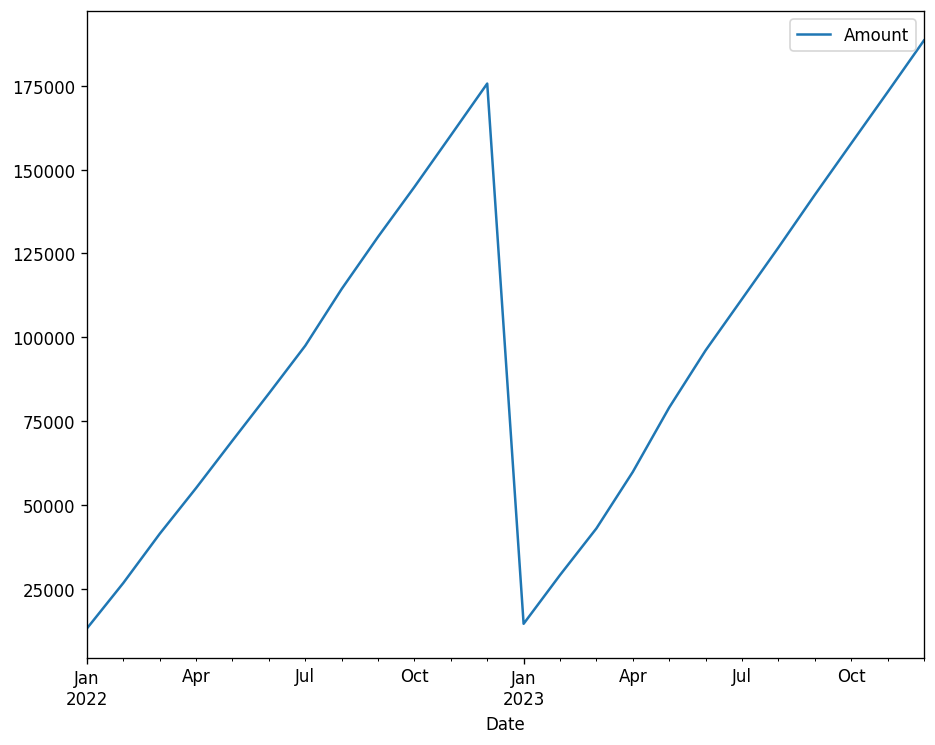

In [381]:
arima_data.plot()

# NOTE: Here it is visible that the data is not stationary and requires differentiation. 

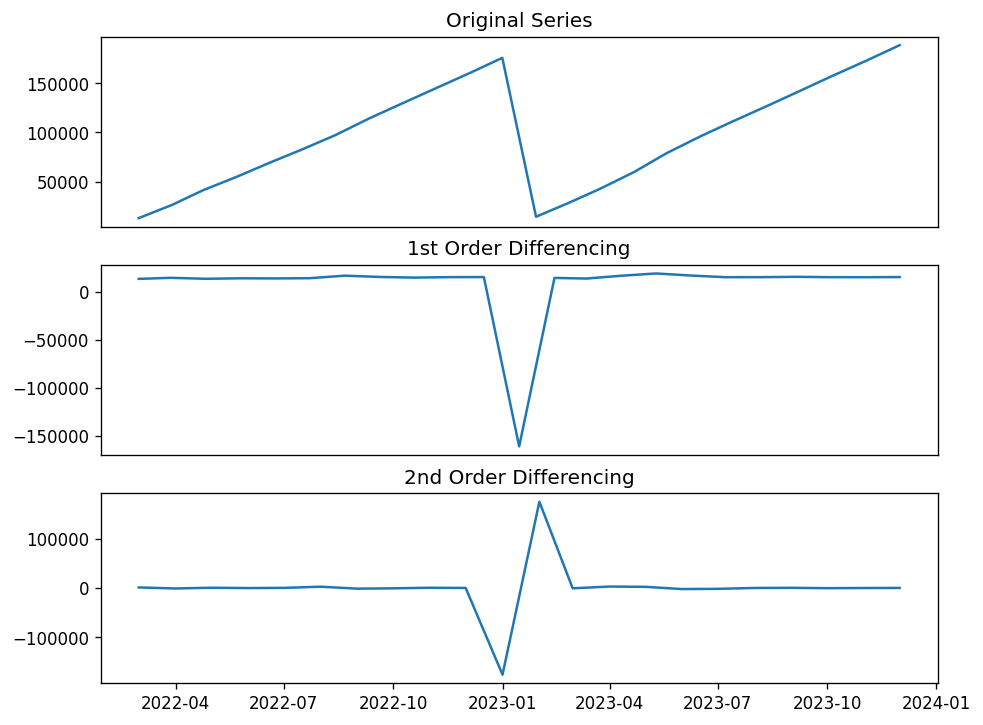

In [382]:
# Step 2: Finding the value of the d parameter 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(arima_data[target_col]); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(arima_data[target_col].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(arima_data[target_col].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()


# NOTE: 2nd order probably the best that it shows better stationarity

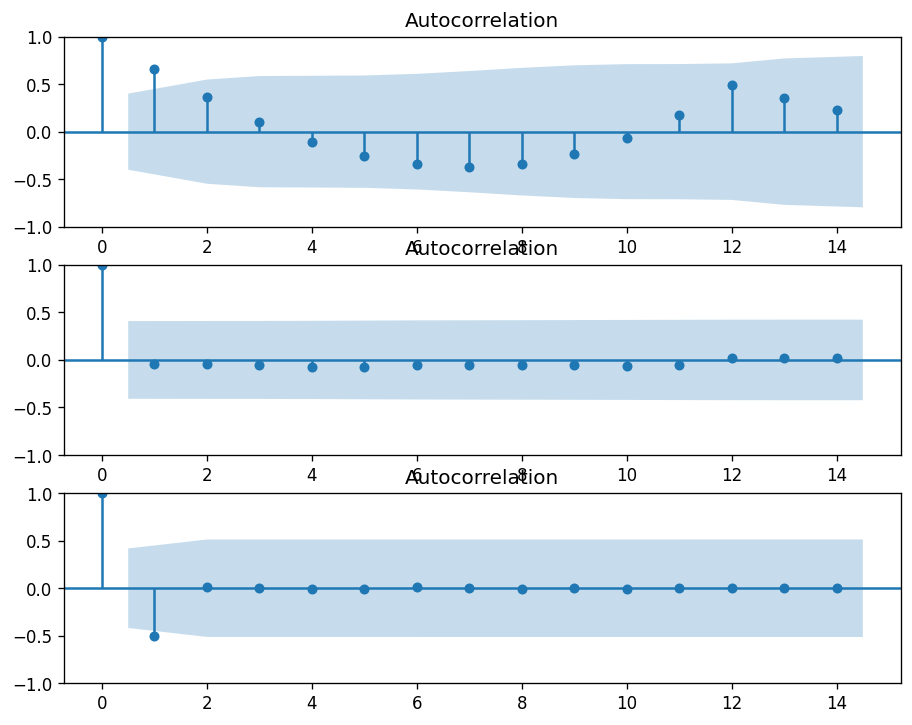

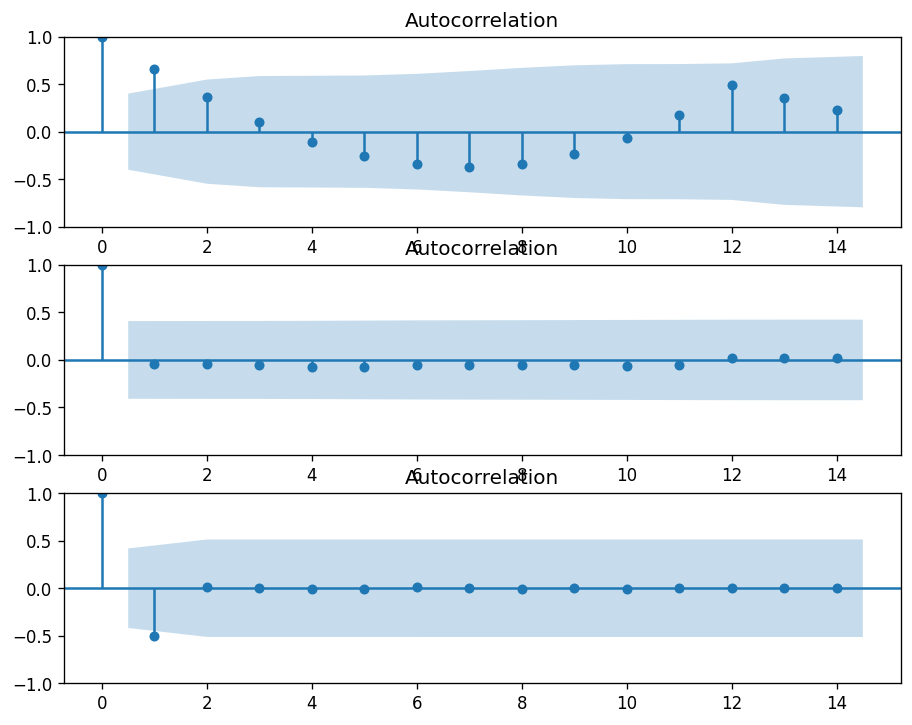

In [383]:
# Plot Auto Correlation Function (ACF) to double check
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(arima_data[target_col], ax=ax1)
plot_acf(arima_data[target_col].diff().dropna(), ax=ax2)
plot_acf(arima_data[target_col].diff().diff().dropna(), ax=ax3)

# Here we can see that in second-order differencing the immediate lag has gone on the negative side, representing that in the second-order the series has become over the difference. 
# Probably use 1st order as the 2nd order seems to be over differencing

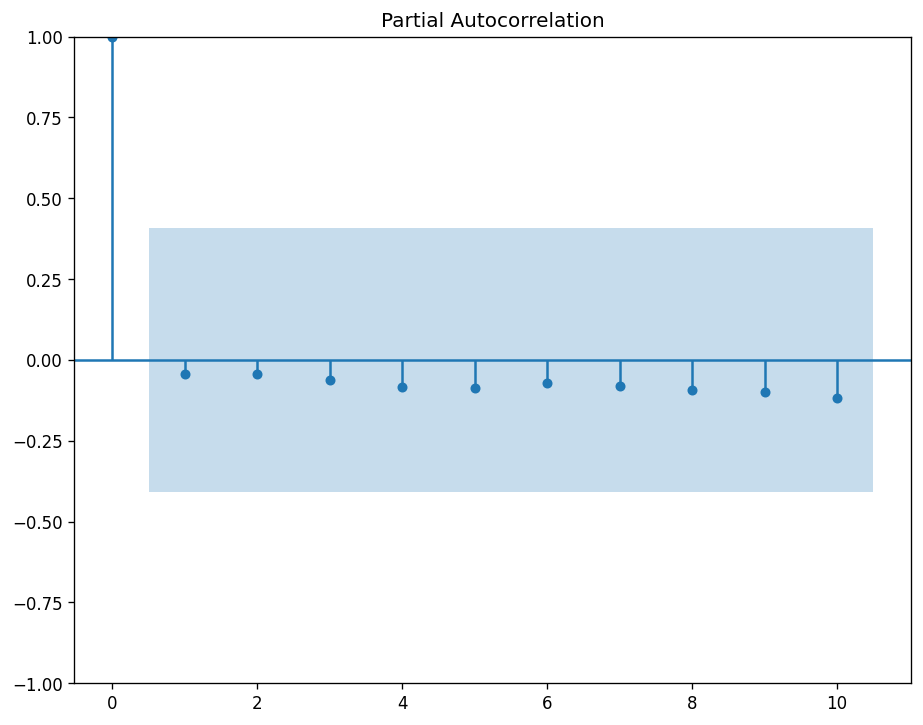

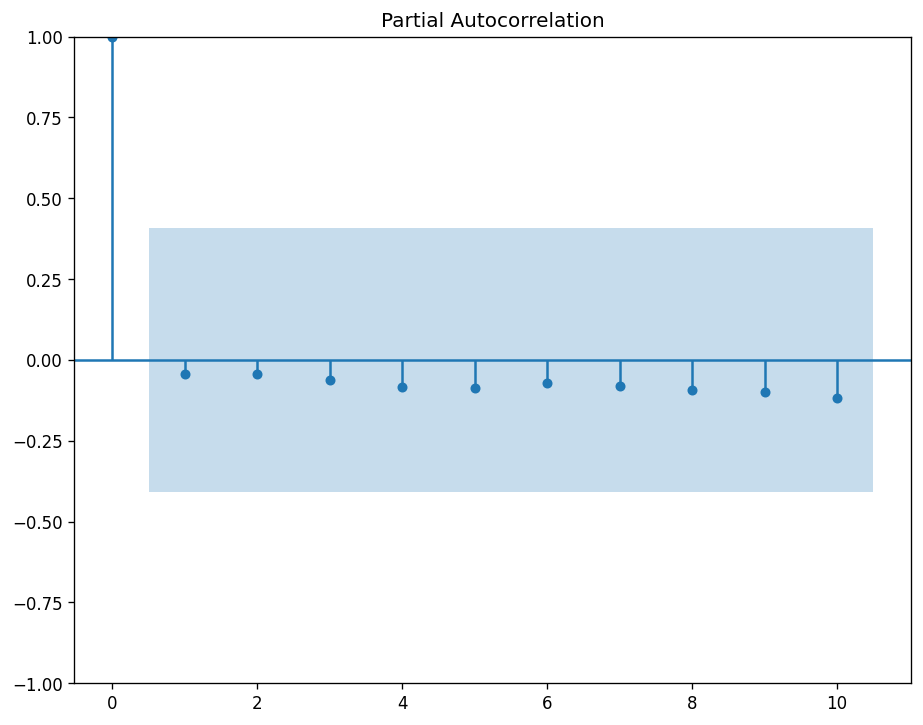

In [384]:
# Step 3: Find the optimal p using PACF plot
from statsmodels.graphics.tsaplots import plot_pacf

# Adjust the number of lags based on your dataset's sample size
max_lags = min(len(arima_data[target_col].diff().dropna()) // 2, 11)

# Here we use 1st order of differencing to check if its in the limit
plot_pacf(arima_data[target_col].diff().dropna(), lags=max_lags-1)

# NOTE: Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 1. 

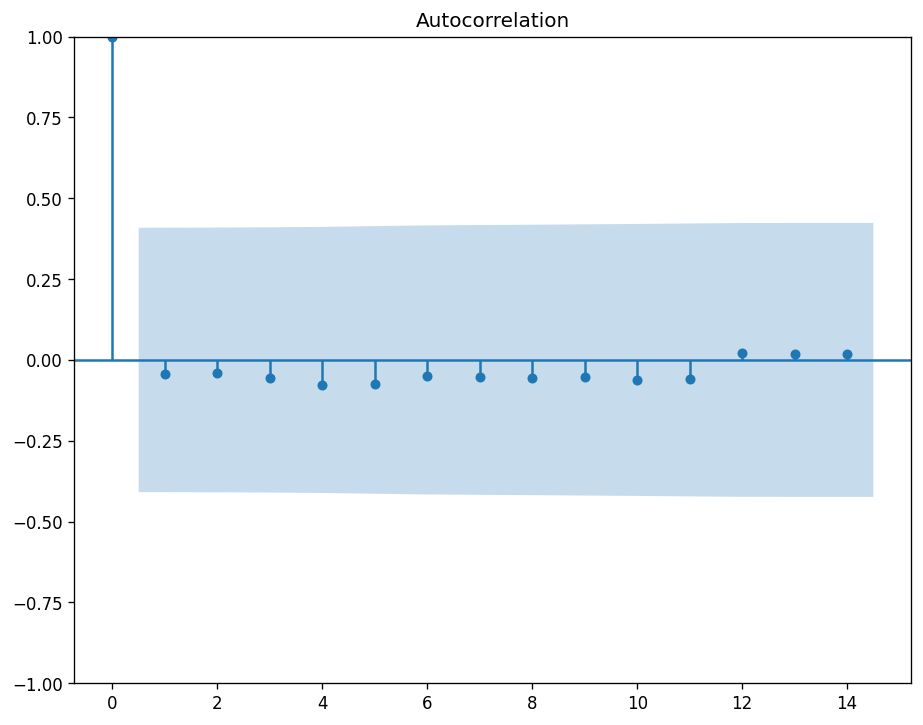

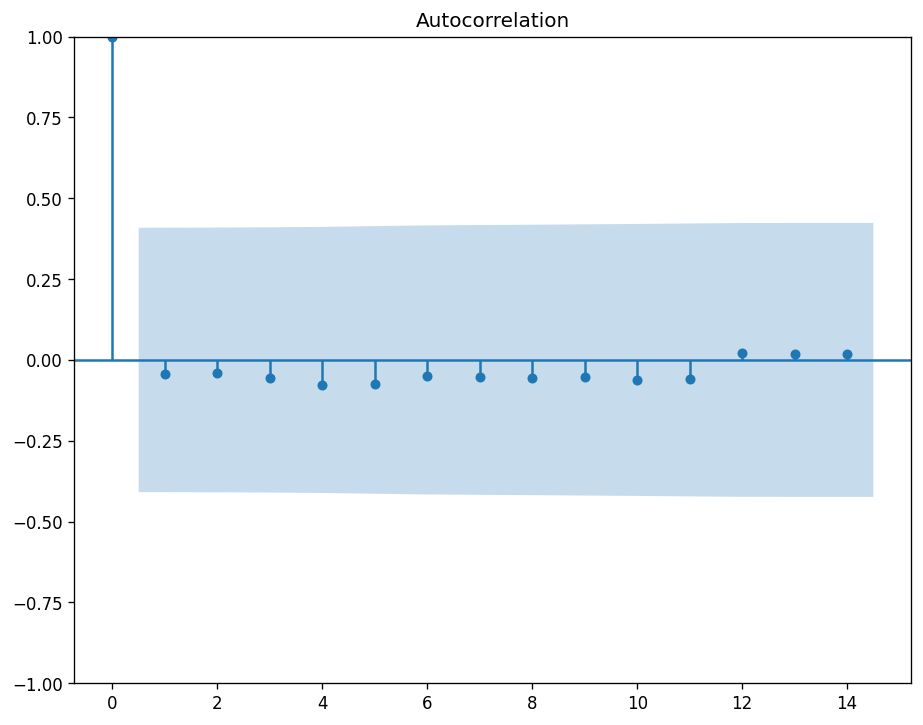

In [385]:
# Step 4: Find the optimal q using ACF plot
plot_acf(arima_data[target_col].diff().dropna())

# NOTE: Here we can see that 2 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 2. 

In [386]:
from statsmodels.tsa.arima.model import ARIMA

# Step 4: Fit an ARIMA model using the p, d, q
# d = 1 doesnt seem to work as the trend is trending downwards, trying on 2 - redo the tests
model = ARIMA(y_train, order=(2, 0, 1))  # Specify appropriate values for p, d, and q
model_fit = model.fit()

# Step 5: Make predictions
y_pred = model_fit.forecast(steps=12)
y_pred

/home/kennysim/anaconda3/envs/kennysim/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2023-08-01    96554.271693
2023-09-01    84034.668813
2023-10-01    75172.591966
2023-11-01    70249.223712
2023-12-01    68792.995550
2024-01-01    69906.464729
2024-02-01    72556.951472
2024-03-01    75794.153902
2024-04-01    78882.307751
2024-05-01    81352.874657
2024-06-01    82995.093087
2024-07-01    83806.433834
Freq: MS, Name: predicted_mean, dtype: float64

In [387]:
# Check the fitted model summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Amount   No. Observations:                   19
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -225.871
Date:                Tue, 22 Aug 2023   AIC                            461.743
Time:                        13:23:20   BIC                            466.465
Sample:                    01-01-2022   HQIC                           462.542
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.126e+04   1.82e+04      4.463      0.000    4.56e+04    1.17e+05
ar.L1          1.5031      0.320      4.695      0.000       0.876       2.131
ar.L2         -0.6708      0.397     -1.689      0.091      -1.449       0.108
ma.L1         -0.9333      0.686     -1.361      0.173      -2.277       0.410
sigma2      1.415e+09      0.049   2.89e+10      0.000    1.42e+09    1.42e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                12.98
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -1.44
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.96e+27. Standard errors may be unstable.
"""

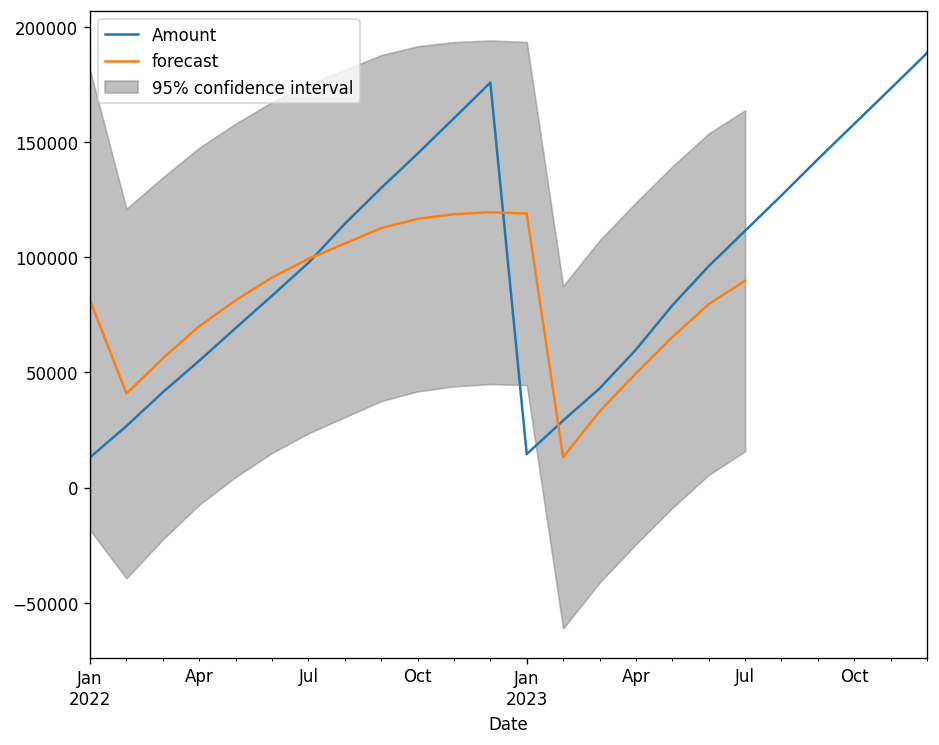

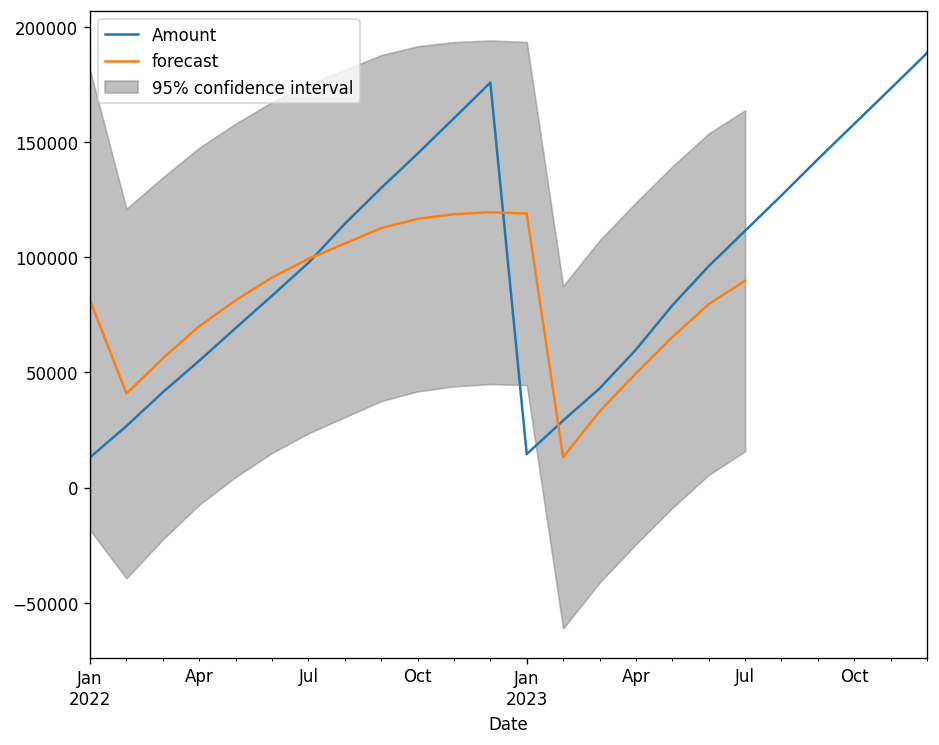

In [388]:
# Check the backtest using the fitted model to see the accuracy
fig, ax = plt.subplots()
ax = arima_data.plot(ax=ax)
plot_predict(model_fit, ax=ax)

In [389]:
# Visualisation

# Get actual by entity dataframe
actual_by_entity = (
    # Parse datetime
    lr_data.assign(Date=lambda df: pd.to_datetime(df["Date"]))
    # Rename target_col to Actual
    .rename(columns={"Amount": "Actual"})
    # Drop entity_col
    .drop("Level4", axis=1)
    .set_index("Date")
)

# Get manual dataframe in same format
manual_by_entity = (
    manual.reset_index()
    # Filter by selected entity
    .pipe(lambda df: df[df[entity_col] == entity])
    # Rename target_col to Actual
    .rename(columns={"Amount": "Manual"})
    # Drop entity_col
    .drop("Level4", axis=1)
    # Set index as Date
    .set_index("Date")
)
# Change colname to Forecast
forecast_by_entity = pd.DataFrame(y_pred).rename(columns={"predicted_mean": "Forecast"})
# Combine actual, manual and forecast into single dataframe
chart_data = actual_by_entity.join(manual_by_entity).join(forecast_by_entity, how="outer")


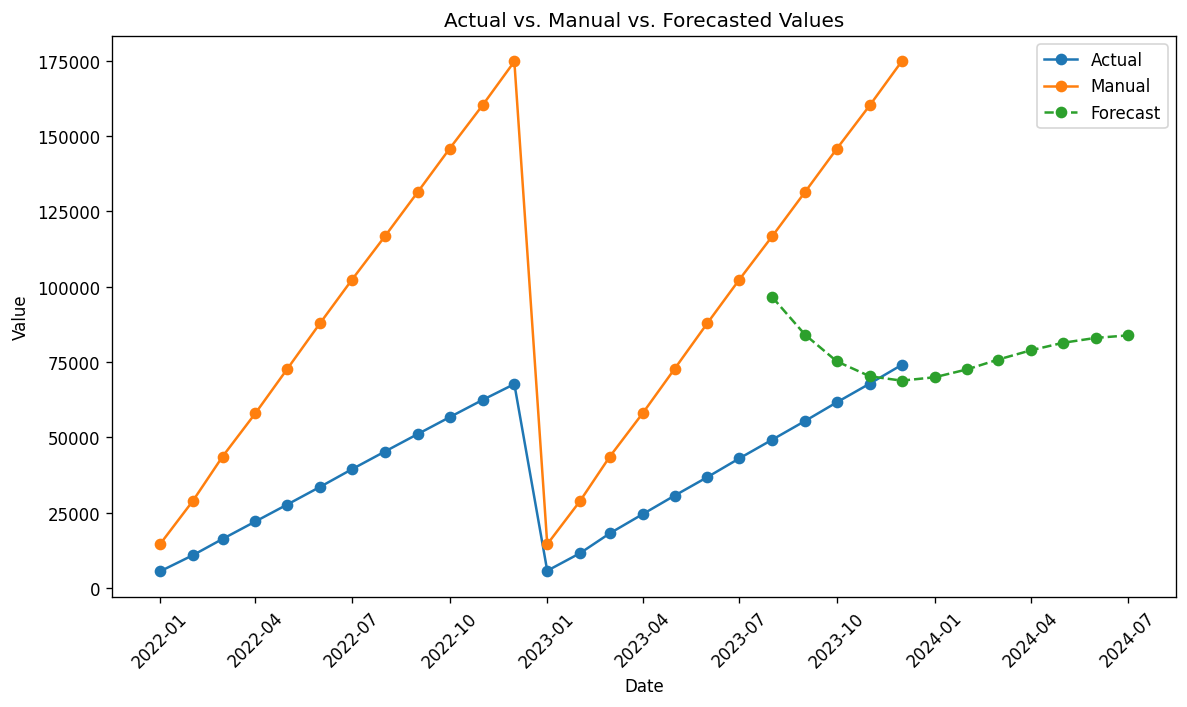

In [390]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot actual values
ax.plot(chart_data.index, chart_data['Actual'], marker='o', label='Actual')
# Plot manual values
ax.plot(chart_data.index, chart_data['Manual'], marker='o', label='Manual')
# Plot forecasted values
ax.plot(chart_data.index, chart_data['Forecast'], marker='o', linestyle='dashed', label='Forecast')
# Add title and labels
ax.set_title('Actual vs. Manual vs. Forecasted Values')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
# Add legend
ax.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Show the plot
plt.tight_layout()
plt.show()

# Machine Learning - Using MLForecast (Ensemble)

In [364]:
# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from mlforecast import MLForecast
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from window_ops.expanding import expanding_mean

In [27]:
TEST_SIZE = 7 # 70% Test, 30% Train
N_SPLITS = 3 # Default number of splits

In [28]:
entity_col = "Level4"
time_col = "Date"
target_col = "Amount"

In [29]:
# Define the TimeSeriesSplit from sklearn
tscv = TimeSeriesSplit(n_splits=N_SPLITS, test_size=TEST_SIZE)

# Split the time series by entity_col
ts_splits_by_entity_col = panel_data.groupby(entity_col).apply(
    lambda x: list(tscv.split(x))
)

In [30]:
# Splitting the time series data by index and return a dictionary of n_splits: array(test/train)
train_by_splits = {}
test_by_splits = {}
for i, ts_split in enumerate(ts_splits_by_entity_col):
    # Filter y data by the index from the ts_split
    y = panel_data[panel_data.index.get_level_values(0)==ts_splits_by_entity_col.index[i]]
    for n_split, (train_index, test_index) in enumerate(ts_split):
        # Split based on train/test 
        train_dataset = y.iloc[train_index]
        test_dataset = y.iloc[test_index]
        if n_split not in train_by_splits.keys():
            train_by_splits[n_split] = []
            test_by_splits[n_split] = []
        
        # Append train and test dataset to the defined dictionary
        train_by_splits[n_split].append(train_dataset)
        test_by_splits[n_split].append(test_dataset)
        
# Concatenate the list of dataframes for train and test datasets by each split
for n_split in range(N_SPLITS):
    train_by_splits[n_split] = pd.concat(train_by_splits[n_split])
    test_by_splits[n_split] = pd.concat(test_by_splits[n_split])

In [31]:
# Snapshot of the splits
# Check if both train and test set has same number of split as N_SPLITS = 3
print(f"Number of splits for train set: {len(train_by_splits.keys())}")
print(f"Number of splits for test set: {len(train_by_splits.keys())}")

# Check if all the countries/entity_col is similar
print(f"Number of {entity_col} in the dataset: {ts_splits_by_entity_col.index.nunique()}")
print(f"Number of {entity_col} (train dataset) for the first split: {train_by_splits[0].index.levels[0].nunique()}")
print(f"Number of {entity_col} for (test dataset) for the first split: {test_by_splits[0].index.levels[0].nunique()}")

Number of splits for train set: 3
Number of splits for test set: 3
Number of Level4 in the dataset: 28
Number of Level4 (train dataset) for the first split: 28
Number of Level4 for (test dataset) for the first split: 28


## Backtesting the ML Models

It involves testing a model, strategy, or algorithm on historical data to evaluate its performance and understand how well it would have worked in the past. The importance of backtesting can be summarized as follows:

In [32]:
SELECTED_MODELS = [
    LinearRegression(),
    RandomForestRegressor(random_state=28),
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
]

In [33]:
backtests = []
for n in range(N_SPLITS):
    train = train_by_splits[n].reset_index()
    # Assign the model for forecasting
    backtest_model = MLForecast(
        models=SELECTED_MODELS,
        freq="MS",
        # Lags = Use of past observations of a time series as input features for predicting future values
        # the number represents the last value, 1 = last time period, 12 = 12 months before (if freq = MS)
        # lags=[1, 12],
        #  It allows the model to capture long-term trends and evolving patterns that might not be immediately apparent from the raw lagged values alone
        lag_transforms={
            1: [expanding_mean],
        },
        # Based on local machine
        num_threads=12,
    )
    print(f"backtest_model: {backtest_model}")

    # Fit the backtest model with the appropriate feature names
    backtest_model.fit(train, id_col=entity_col, time_col=time_col, target_col=target_col)

    # Backtest the model
    backtest = backtest_model.predict(TEST_SIZE)
    backtests.append(backtest)

backtest_model: MLForecast(models=[LinearRegression, RandomForestRegressor, LGBMRegressor, XGBRegressor], freq=<MonthBegin>, lag_features=['expanding_mean_lag1'], date_features=[], num_threads=12)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1
[LightGBM] [Info] Start training from score 15858.321329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [34]:
# Combine the list of dataset from each entity_col to single dataframe
backtest = (
    pd.concat(backtests).set_index([entity_col, time_col])
    # The ensemble value would be the mean of all the 4 models
    .assign(Ensemble=lambda df: df.mean(axis=1))
    # Round the values to 2 d.a.
    .round(2)
)
backtest

LinearRegression  RandomForestRegressor  \
Level4               Date                                                  
AGILE Coaches        2022-04-01           2259.95                2343.33   
                     2022-05-01           2817.29                3155.62   
                     2022-06-01           3378.55                3502.46   
                     2022-07-01           3943.09                4270.69   
                     2022-08-01           4510.46                5239.71   
...                                           ...                    ...   
Project RACE Program 2023-08-01           8099.37                6646.77   
                     2023-09-01           8405.88                3108.27   
                     2023-10-01           8700.68                4519.81   
                     2023-11-01           8984.70                4003.33   
                     2023-12-01           9258.81                3427.40   

                                 LGBMRegressor  XGBRegressor  Ensemble  
Level4               Date                                               
AGILE Coaches        2022-04-01        2214.76   2512.969971   2332.75  
                     2022-05-01        3537.59   3315.520020   3206.51  
                     2022-06-01        3537.59   4221.750000   3660.09  
                     2022-07-01        3537.59   4221.750000   3993.28  
                     2022-08-01        6953.04   5093.870117   5449.27  
...                                        ...           ...       ...  
Project RACE Program 2023-08-01        8620.00   4990.819824   7089.24  
                     2023-09-01        4302.47   4310.549805   5031.79  
                     2023-10-01        4302.47   4310.549805   5458.38  
                     2023-11-01        4302.47   3708.600098   5249.78  
                     2023-12-01        4302.47   2354.560059   4835.81  

[588 rows x 5 columns]

# Forecasting

In [35]:
# Assign the model for forecasting
forecast_model = MLForecast(
    models=SELECTED_MODELS,
    freq="MS",
    # lags=[1, 12],
    lag_transforms={
        1: [expanding_mean],
    },
    num_threads=12,
)

# Fitting
forecast_model.fit(panel_data.reset_index(), id_col=entity_col, time_col=time_col, target_col=target_col)

# Predict for backtest
forecast = (
    # Predict for 12 months ahead
    forecast_model.predict(12)
    .set_index([entity_col, time_col])
    # The ensemble value would be the mean of all the 4 models
    .assign(Ensemble=lambda df: df.mean(axis=1))
    # Round the values to 2 d.p.
    .round(2)
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 644, number of used features: 1
[LightGBM] [Info] Start training from score 44013.548550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [36]:
forecast

LinearRegression  RandomForestRegressor  \
Level4               Date                                                  
AGILE Coaches        2024-01-01           4401.94                3491.54   
                     2024-02-01           4550.50                1390.42   
                     2024-03-01           4695.50                3833.51   
                     2024-04-01           4837.14                2754.86   
                     2024-05-01           4975.64                1845.96   
...                                           ...                    ...   
Project RACE Program 2024-08-01           6676.23                1842.11   
                     2024-09-01           6819.07                1051.95   
                     2024-10-01           6959.21                6112.95   
                     2024-11-01           7096.78                3250.95   
                     2024-12-01           7231.91                3957.23   

                                 LGBMRegressor  XGBRegressor  Ensemble  
Level4               Date                                               
AGILE Coaches        2024-01-01        3010.86   2519.560059   3355.98  
                     2024-02-01        2573.56   2519.560059   2758.51  
                     2024-03-01        2573.56   2519.560059   3405.53  
                     2024-04-01        2367.36   2519.560059   3119.73  
                     2024-05-01        2367.36   2519.560059   2927.13  
...                                        ...           ...       ...  
Project RACE Program 2024-08-01        5077.52   4035.419922   4407.82  
                     2024-09-01        5077.52   4035.419922   4245.99  
                     2024-10-01        4555.25   4035.419922   5415.71  
                     2024-11-01        4796.10   4616.109863   4939.99  
                     2024-12-01        3341.15   4616.109863   4786.60  

[336 rows x 5 columns]

# Compute Scores for the models

In [37]:
dates = backtest.index.get_level_values(1).unique()
dates

DatetimeIndex(['2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [38]:
panel_data

Amount
Level4               Date                   
AGILE Coaches        2022-01-01   535.704551
                     2022-02-01  1085.919443
                     2022-03-01  1871.860783
                     2022-04-01  2442.484811
                     2022-05-01  2968.431818
...                                      ...
Project RACE Program 2023-08-01  2951.232876
                     2023-09-01  2951.232876
                     2023-10-01  2951.232876
                     2023-11-01  2951.232876
                     2023-12-01  2951.232876

[672 rows x 1 columns]

In [39]:
comparison_df = panel_data.join(backtest)
comparison_df

Amount  LinearRegression  \
Level4               Date                                        
AGILE Coaches        2022-01-01   535.704551               NaN   
                     2022-02-01  1085.919443               NaN   
                     2022-03-01  1871.860783               NaN   
                     2022-04-01  2442.484811           2259.95   
                     2022-05-01  2968.431818           2817.29   
...                                      ...               ...   
Project RACE Program 2023-08-01  2951.232876           8099.37   
                     2023-09-01  2951.232876           8405.88   
                     2023-10-01  2951.232876           8700.68   
                     2023-11-01  2951.232876           8984.70   
                     2023-12-01  2951.232876           9258.81   

                                 RandomForestRegressor  LGBMRegressor  \
Level4               Date                                               
AGILE Coaches        2022-01-01                    NaN            NaN   
                     2022-02-01                    NaN            NaN   
                     2022-03-01                    NaN            NaN   
                     2022-04-01                2343.33        2214.76   
                     2022-05-01                3155.62        3537.59   
...                                                ...            ...   
Project RACE Program 2023-08-01                6646.77        8620.00   
                     2023-09-01                3108.27        4302.47   
                     2023-10-01                4519.81        4302.47   
                     2023-11-01                4003.33        4302.47   
                     2023-12-01                3427.40        4302.47   

                                 XGBRegressor  Ensemble  
Level4               Date                                
AGILE Coaches        2022-01-01           NaN       NaN  
                     2022-02-01           NaN       NaN  
                     2022-03-01           NaN       NaN  
                     2022-04-01   2512.969971   2332.75  
                     2022-05-01   3315.520020   3206.51  
...                                       ...       ...  
Project RACE Program 2023-08-01   4990.819824   7089.24  
                     2023-09-01   4310.549805   5031.79  
                     2023-10-01   4310.549805   5458.38  
                     2023-11-01   3708.600098   5249.78  
                     2023-12-01   2354.560059   4835.81  

[672 rows x 6 columns]

# Compute Metrics

In [40]:
def compute_score(row, col_name, metric, target_col):
    return metric(row[target_col], row[col_name])

In [41]:
metrics = {
    "mse": mean_squared_error, 
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error
}

In [42]:
scores = (
    comparison_df
    # NOTE: Replaced NaNs with 0 for metrics
    .replace({np.nan: 0})
    .groupby(entity_col, group_keys=True)
    .agg(list)
    # Compute scores
    .pipe(
        lambda df: df.assign(
            **{
                f"{col}_{metric_name}": df.apply(lambda s: compute_score(s, col, metric, target_col), axis=1)
                for col in df.columns if col != target_col
                for metric_name, metric in metrics.items()
            }
        )
    )
    .filter(regex="_mae|_mape|_mse")
)
scores

,LinearRegression_mse,LinearRegression_mae,LinearRegression_mape,RandomForestRegressor_mse,RandomForestRegressor_mae,RandomForestRegressor_mape,LGBMRegressor_mse,LGBMRegressor_mae,LGBMRegressor_mape,XGBRegressor_mse,XGBRegressor_mae,XGBRegressor_mape,Ensemble_mse,Ensemble_mae,Ensemble_mape
Level4,,,,,,,,,,,,,,,
AGILE Coaches,3.763370e+07,4628.154307,1.935256e+19,2.549037e+07,3796.857333,1.474371e+19,2.319105e+07,3795.241262,1.421153e+19,2.175209e+07,3587.296491,1.331514e+19,2.555301e+07,3940.746916,1.540574e+19
Group Asset Management,1.040700e+09,20188.735571,1.341105e+00,1.138541e+09,21977.375973,1.369646e+00,1.022767e+09,22190.319045,1.350509e+00,1.153211e+09,22707.772800,1.370333e+00,1.065448e+09,20943.839838,1.338598e+00
Group Community Banking,1.390952e+11,225322.518798,1.392935e+00,9.360128e+10,267730.750776,1.155500e+00,1.027965e+11,273191.261619,7.807654e-01,9.378820e+10,265085.706222,1.179511e+00,8.264954e+10,252748.036014,1.115133e+00
Group Compliance,2.586148e+08,9350.015404,1.356503e+00,2.971047e+08,11410.737236,1.464162e+00,3.712829e+08,14307.298081,1.717650e+00,2.924701e+08,10710.787324,1.441138e+00,2.745482e+08,10574.917805,1.454168e+00
Group Finance,6.811004e+08,15223.270306,1.400682e+00,7.106877e+08,16560.367746,1.408413e+00,7.167646e+08,18112.673702,1.549212e+00,7.125388e+08,16333.947058,1.392631e+00,6.813262e+08,15916.337271,1.421683e+00
Group Human Resource,8.649828e+06,2229.725425,3.814694e+00,9.207406e+05,762.228233,2.098350e+00,8.202969e+05,768.248279,2.113955e+00,8.722037e+05,735.781136,2.040348e+00,1.063509e+06,855.531058,2.239914e+00
Group Insurance,1.044059e+09,19373.213579,1.300427e+00,1.187038e+09,22958.898579,1.367879e+00,1.048324e+09,22608.225825,1.341564e+00,1.179573e+09,22963.727534,1.350384e+00,1.096282e+09,21732.347491,1.332462e+00
Group Internal Audit,1.653977e+08,7479.712709,1.231590e+00,1.940421e+08,9413.467744,1.321209e+00,3.101507e+08,14177.062755,1.652130e+00,1.726778e+08,7688.989371,1.242745e+00,1.806744e+08,9041.496505,1.327156e+00
Group International Business,2.583876e+10,102486.494118,1.252574e+00,2.864859e+10,122679.389179,1.331321e+00,1.715961e+10,112867.455383,1.077243e+00,3.139749e+10,125380.487355,1.382069e+00,2.223467e+10,109246.456870,1.228717e+00


In [43]:
def rank_by_metric(
    df: pd.DataFrame, metric: str, entity_col: str, target_col: str, is_asc: bool = "True"
):
    scores = (
        df.filter(regex=f"_{metric}")
        .pipe(
            lambda df: df.rename(
                {col: col.replace(f"_{metric}", "") for col in df.columns}, axis=1
            )
        )
        .stack()
        .rename_axis([entity_col, "model"])
        .rename(metric)
        .reset_index()
        .pipe(lambda df: df.loc[df.groupby(entity_col)[metric].idxmin()])
        # Sort and rank from lowest to highest
        .sort_values(metric)
        .assign(rank=lambda df: df[metric].rank(), ascending=is_asc)
        .astype({"rank": "int64"})
        .set_index("rank")
        .loc[:,[entity_col, "model", metric]]
    )
    return scores

In [44]:
# Top 5 country rank by mae (all models)
rank_by_mae = rank_by_metric(df=scores, metric="mae", entity_col=entity_col, target_col=target_col)
rank_by_mae.head()

,Level4,model,mae
rank,,,
1,Project Mgmt & Transformation,Ensemble,256.965125
2,Group Human Resource,XGBRegressor,735.781136
3,Mgt. Assoc. Programme,RandomForestRegressor,951.601564
4,HR Business Partner,XGBRegressor,1089.727740
5,Group Sustainability & Corporate Communications,Ensemble,1832.920654


In [45]:
# Top 5 country rank by mape (all models)
rank_by_mape = rank_by_metric(df=scores, metric="mape", entity_col="country", target_col="cpi")
rank_by_mape.head()

,country,model,mape
rank,,,
1,Group Community Banking,LGBMRegressor,0.780765
2,HR Center of Excellence (CoE),XGBRegressor,0.922595
3,Group Managing Director's Office,Ensemble,0.986775
4,"Group Legal, Secretariat & Gov",XGBRegressor,1.038423
5,Group International Business,LGBMRegressor,1.077243


In [46]:
# Top 5 country rank by mse (all models)
rank_by_mse = rank_by_metric(df=scores, metric="mse", entity_col="country", target_col="cpi")
rank_by_mse.head()

,country,model,mse
rank,,,
1,Project Mgmt & Transformation,Ensemble,1.168338e+05
2,Group Human Resource,LGBMRegressor,8.202969e+05
3,Mgt. Assoc. Programme,RandomForestRegressor,2.302220e+06
4,HR Business Partner,XGBRegressor,3.401202e+06
5,Project RACE Program,XGBRegressor,7.923930e+06


# Visualisation of output

In [47]:
# Get all historical data up to last 10 years
historical_data = (
    panel_data
    .join(
        backtest
    )
    # Filter last 5 yrs
    .groupby(entity_col)
    .tail(120)
)
historical_data

Amount  LinearRegression  \
Level4               Date                                        
AGILE Coaches        2022-01-01   535.704551               NaN   
                     2022-02-01  1085.919443               NaN   
                     2022-03-01  1871.860783               NaN   
                     2022-04-01  2442.484811           2259.95   
                     2022-05-01  2968.431818           2817.29   
...                                      ...               ...   
Project RACE Program 2023-08-01  2951.232876           8099.37   
                     2023-09-01  2951.232876           8405.88   
                     2023-10-01  2951.232876           8700.68   
                     2023-11-01  2951.232876           8984.70   
                     2023-12-01  2951.232876           9258.81   

                                 RandomForestRegressor  LGBMRegressor  \
Level4               Date                                               
AGILE Coaches        2022-01-01                    NaN            NaN   
                     2022-02-01                    NaN            NaN   
                     2022-03-01                    NaN            NaN   
                     2022-04-01                2343.33        2214.76   
                     2022-05-01                3155.62        3537.59   
...                                                ...            ...   
Project RACE Program 2023-08-01                6646.77        8620.00   
                     2023-09-01                3108.27        4302.47   
                     2023-10-01                4519.81        4302.47   
                     2023-11-01                4003.33        4302.47   
                     2023-12-01                3427.40        4302.47   

                                 XGBRegressor  Ensemble  
Level4               Date                                
AGILE Coaches        2022-01-01           NaN       NaN  
                     2022-02-01           NaN       NaN  
                     2022-03-01           NaN       NaN  
                     2022-04-01   2512.969971   2332.75  
                     2022-05-01   3315.520020   3206.51  
...                                       ...       ...  
Project RACE Program 2023-08-01   4990.819824   7089.24  
                     2023-09-01   4310.549805   5031.79  
                     2023-10-01   4310.549805   5458.38  
                     2023-11-01   3708.600098   5249.78  
                     2023-12-01   2354.560059   4835.81  

[672 rows x 6 columns]

In [48]:
future_data = forecast.assign(Amount=np.NaN)
future_data

LinearRegression  RandomForestRegressor  \
Level4               Date                                                  
AGILE Coaches        2024-01-01           4401.94                3491.54   
                     2024-02-01           4550.50                1390.42   
                     2024-03-01           4695.50                3833.51   
                     2024-04-01           4837.14                2754.86   
                     2024-05-01           4975.64                1845.96   
...                                           ...                    ...   
Project RACE Program 2024-08-01           6676.23                1842.11   
                     2024-09-01           6819.07                1051.95   
                     2024-10-01           6959.21                6112.95   
                     2024-11-01           7096.78                3250.95   
                     2024-12-01           7231.91                3957.23   

                                 LGBMRegressor  XGBRegressor  Ensemble  Amount  
Level4               Date                                                       
AGILE Coaches        2024-01-01        3010.86   2519.560059   3355.98     NaN  
                     2024-02-01        2573.56   2519.560059   2758.51     NaN  
                     2024-03-01        2573.56   2519.560059   3405.53     NaN  
                     2024-04-01        2367.36   2519.560059   3119.73     NaN  
                     2024-05-01        2367.36   2519.560059   2927.13     NaN  
...                                        ...           ...       ...     ...  
Project RACE Program 2024-08-01        5077.52   4035.419922   4407.82     NaN  
                     2024-09-01        5077.52   4035.419922   4245.99     NaN  
                     2024-10-01        4555.25   4035.419922   5415.71     NaN  
                     2024-11-01        4796.10   4616.109863   4939.99     NaN  
                     2024-12-01        3341.15   4616.109863   4786.60     NaN  

[336 rows x 6 columns]

In [49]:
chart_data = (
    pd.concat([historical_data, future_data])
    .assign(Amount=lambda df: df[target_col].astype(float))
    # .groupby(entity_col)
)
chart_data

Amount  LinearRegression  \
Level4               Date                                        
AGILE Coaches        2022-01-01   535.704551               NaN   
                     2022-02-01  1085.919443               NaN   
                     2022-03-01  1871.860783               NaN   
                     2022-04-01  2442.484811           2259.95   
                     2022-05-01  2968.431818           2817.29   
...                                      ...               ...   
Project RACE Program 2024-08-01          NaN           6676.23   
                     2024-09-01          NaN           6819.07   
                     2024-10-01          NaN           6959.21   
                     2024-11-01          NaN           7096.78   
                     2024-12-01          NaN           7231.91   

                                 RandomForestRegressor  LGBMRegressor  \
Level4               Date                                               
AGILE Coaches        2022-01-01                    NaN            NaN   
                     2022-02-01                    NaN            NaN   
                     2022-03-01                    NaN            NaN   
                     2022-04-01                2343.33        2214.76   
                     2022-05-01                3155.62        3537.59   
...                                                ...            ...   
Project RACE Program 2024-08-01                1842.11        5077.52   
                     2024-09-01                1051.95        5077.52   
                     2024-10-01                6112.95        4555.25   
                     2024-11-01                3250.95        4796.10   
                     2024-12-01                3957.23        3341.15   

                                 XGBRegressor  Ensemble  
Level4               Date                                
AGILE Coaches        2022-01-01           NaN       NaN  
                     2022-02-01           NaN       NaN  
                     2022-03-01           NaN       NaN  
                     2022-04-01   2512.969971   2332.75  
                     2022-05-01   3315.520020   3206.51  
...                                       ...       ...  
Project RACE Program 2024-08-01   4035.419922   4407.82  
                     2024-09-01   4035.419922   4245.99  
                     2024-10-01   4035.419922   5415.71  
                     2024-11-01   4616.109863   4939.99  
                     2024-12-01   4616.109863   4786.60  

[1008 rows x 6 columns]

In [50]:
# Visualize entity with lowest mae
entity = rank_by_mae.iloc[0][entity_col]
best_model = rank_by_mae.iloc[0]["model"]
mae = rank_by_mae.iloc[0]["mae"]
print(f"Best model for {entity_col} is {best_model} with MAE: {round(mae, 2)}")

Best model for Level4 is Ensemble with MAE: 256.97


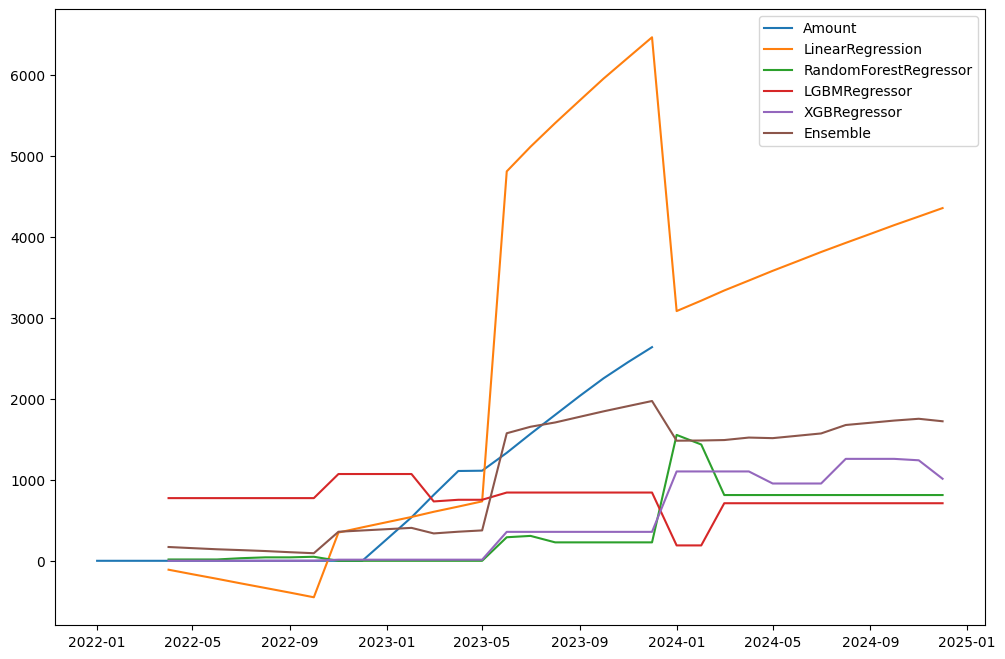

In [51]:
# Filter the chart by country for Best Model
chart_data_filtered = chart_data[chart_data.index.get_level_values(0)==entity].droplevel(0)

# Set figure size to wider
plt.figure(figsize=(12,8))
for col in chart_data_filtered.columns:
    plt.plot(chart_data_filtered.index, chart_data_filtered[col], label=col)
    
plt.legend()